In [1]:
!pip install --upgrade transformers accelerate bitsandbytes

## Import libraries

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
### Data pre-processing imports ###

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

### Custom Model Imports ###
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
from torch.nn import functional as F

from transformers import (
    AutoTokenizer,
    AutoModel,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    TrainerCallback
)

import wandb
import huggingface_hub
from huggingface_hub import PyTorchModelHubMixin

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

2025-11-09 19:48:08.572104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762717688.595427     256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762717688.602348     256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

wandb.login(key=wandb_api)

huggingface_api = user_secrets.get_secret("huggingface_api") 
huggingface_hub.login(token=huggingface_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bheshaj to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
print(torch.cuda.is_available())

True


In [6]:
torch.cuda.is_bf16_supported()

True

## Set config

Set configurations for model

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Backbone model name
MODEL_NAME = "microsoft/deberta-v3-base"

# Max sequence length for input
MAX_SEQUENCE_LENGTH = 512

# Use quantization
USE_4BIT = True

# PEFT/LoRA Params
LORA_TARGETS = ["query_proj", "key_proj", "value_proj", "dense"]
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05

## Import dataset

In [8]:
raw_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/train.csv")
test_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/test.csv")

In [9]:
raw_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [10]:
test_df.head()

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


## EDA

In [11]:
# Check column data types
raw_df.dtypes

id                 int64
model_a           object
model_b           object
prompt            object
response_a        object
response_b        object
winner_model_a     int64
winner_model_b     int64
winner_tie         int64
dtype: object

Count plot of different types models

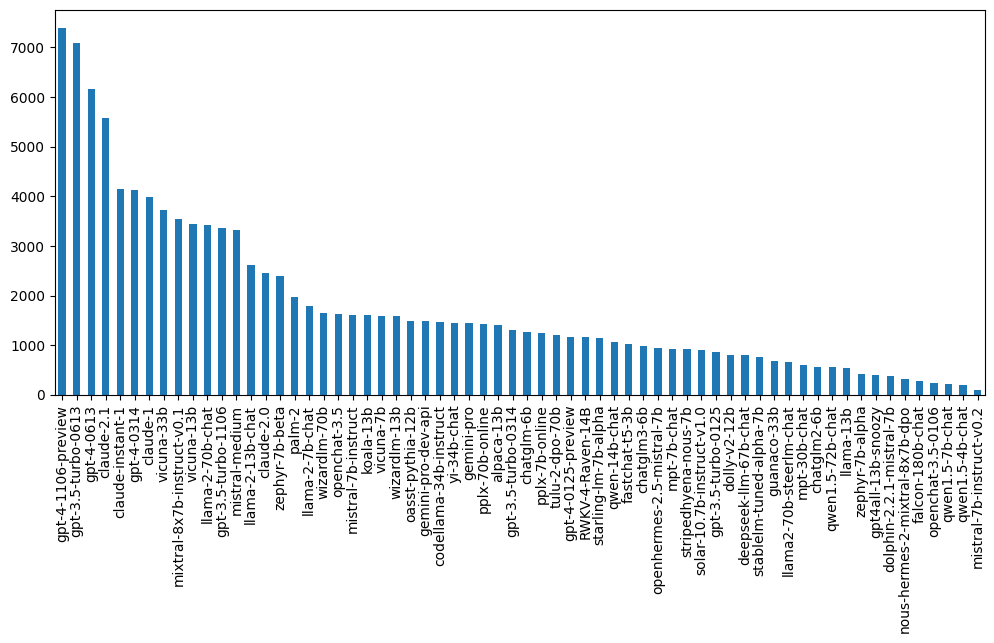

In [12]:
plt.figure(figsize=(12,5))
pd.concat([raw_df['model_a'], raw_df['model_b']]).value_counts().plot(kind='bar', stacked=True)

plt.show()

## Data pre-processing

Prompt and responses are in json format and need parsing

In [13]:
import json

def safe_parse_json(x):
    if not isinstance(x, str):
        return x
    try:
        val = json.loads(x)
        # If it's a list, return first non-null element
        if isinstance(val, list):
            if val:
                return [item if item is not None else '' for item in val]
            else:
                return ''
        return val
    except json.JSONDecodeError:
        return ""

raw_df["response_a_processed"] = raw_df["response_a"].apply(safe_parse_json)
raw_df["response_b_processed"] = raw_df["response_b"].apply(safe_parse_json)
raw_df["prompt_processed"] = raw_df["prompt"].apply(safe_parse_json)

In [14]:
test_df["response_a_processed"] = test_df["response_a"].apply(safe_parse_json)
test_df["response_b_processed"] = test_df["response_b"].apply(safe_parse_json)
test_df["prompt_processed"] = test_df["prompt"].apply(safe_parse_json)

Format query and response in a question-answer format like in a chat

Ex-

Query:
What is the difference between marriage license and marriage certificate?

Response:
A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county clerk's office or a state government, and is valid for a certain period of time, usually one year. After the marriage has taken place, the couple must obtain a marriage certificate, which is a document that records the marriage and is used to prove that the marriage took place. The marriage certificate is usually issued by the same government agency that issued the marriage license, and it is typically used for legal purposes, such as to change a name on a driver's license or to prove that a couple is married when applying for government benefits.

In [15]:
def format_conversation(query_list, response_list):
    parts = []
    for i, (q, r) in enumerate(zip(query_list, response_list)):
        parts.append((f"Query:\n{q}\n\nResponse:\n{r}"))
    return '\n\n'.join(parts)

raw_df['text_a'] = raw_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_a_processed']), axis=1)
raw_df['text_b'] = raw_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_b_processed']), axis=1)

In [16]:
test_df['text_a'] = test_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_a_processed']), axis=1)
test_df['text_b'] = test_df.apply(lambda x: format_conversation(x['prompt_processed'], x['response_b_processed']), axis=1)

Summary statistics for the number of words in the conversation texts. This helps to determine the maximum input sequence length to the model and hence helps decide the model to choose.

The conversations mostly have < 550 words in each conversation. Assuming $ \text{Tokens per conversation} = 1.5 \times \text{Words per conversation} $, we would ideally need a model which can handle ~850 tokens. However, to keep the model easy and simple to train we will use a model with smaller max sequence limit.

In [17]:
word_split = raw_df["text_a"].apply(lambda x: x.split(' '))
word_split.apply(lambda x: len(x)).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90])

count    57477.000000
mean       274.053343
std        330.512938
min          1.000000
5%          23.000000
25%         91.000000
50%        205.000000
75%        340.000000
90%        536.000000
max      10459.000000
Name: text_a, dtype: float64

In [18]:
word_split = raw_df["text_b"].apply(lambda x: x.split(' '))
word_split.apply(lambda x: len(x)).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90])

count    57477.000000
mean       275.752371
std        347.943182
min          1.000000
5%          23.000000
25%         91.000000
50%        206.000000
75%        340.000000
90%        540.000000
max      20764.000000
Name: text_b, dtype: float64

### Create target label

Create a single target column which can help determine the true class

In [19]:
def create_target_col(encoding):
    """
    Create column for target labels
    """

    if encoding == [0, 0, 1]:
        return 'tie'
    elif encoding == [0, 1, 0]:
        return 'model_b'
    elif encoding == [1, 0, 0]:
        return 'model_a'

    return np.nan

raw_df['target'] = raw_df[['winner_model_a', 'winner_model_b', 'winner_tie']].apply(lambda x: create_target_col(list(x)), axis=1)

raw_df['label'] = raw_df['target'].map({'model_a': 0, 'model_b': 1, 'tie': 2})

### Train-test split

In [20]:

train_df, eval_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df["label"])

## Model Architecture

In [ ]:
from dataclasses import dataclass
@dataclass
class PairwiseDataCollatorFixed:
    tokenizer: Any
    padding: str = "longest"   # or "max_length"
    max_length: int = MAX_SEQUENCE_LENGTH

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        features = [f for f in features if f is not None and isinstance(f, dict)]
        if len(features) == 0:
            raise ValueError("Empty batch after filtering None features in collator.")

        for i, f in enumerate(features):
            for k in ("a_input_ids", "a_attention_mask", "b_input_ids", "b_attention_mask"):
                if k not in f:
                    raise ValueError(f"Missing key {k} in feature at batch pos {i}: keys={list(f.keys())}")

        a_feats = [{"input_ids": f["a_input_ids"], "attention_mask": f["a_attention_mask"]} for f in features]
        b_feats = [{"input_ids": f["b_input_ids"], "attention_mask": f["b_attention_mask"]} for f in features]

        pad_kwargs = {"padding": self.padding, "return_tensors": "pt"}
        if self.padding == "max_length":
            pad_kwargs["max_length"] = self.max_length

        a_batch = self.tokenizer.pad(a_feats, **pad_kwargs)
        b_batch = self.tokenizer.pad(b_feats, **pad_kwargs)

        out = {
            "a_input_ids": a_batch["input_ids"],
            "a_attention_mask": a_batch["attention_mask"],
            "b_input_ids": b_batch["input_ids"],
            "b_attention_mask": b_batch["attention_mask"],
        }

        if "labels" in features[0]:
            labels = [int(f["labels"]) for f in features]
            out["labels"] = torch.tensor(labels, dtype=torch.long)

        if "id" in features[0]:
            out["ids"] = [f.get("id") for f in features]

        return out

In [21]:
def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    count = mask.sum(dim=1).clamp(min=1e-9)
    return summed / count

class PairwiseBiEncoder(
    nn.Module, 
    PyTorchModelHubMixin # Required to push the model to huggingface hub
    ):
    """
    Two independent encodes + comparison head -> 3-way logits.
    Expects tokenized dicts for A and B: {input_ids, attention_mask}.
    """
    def __init__(self, encoder: nn.Module, hidden_size: int, num_labels: int = 3, dropout: float = 0.2):
        super().__init__()
        self.num_labels = num_labels
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.config = encoder.config # Needed for peft/LoRA config
        self.classifier = nn.Sequential(
            nn.Linear(4 * hidden_size, 2*hidden_size),
            nn.GELU(),
            nn.Linear(2 * hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, self.num_labels)
        )

    def freeze_backbone(self):
        for name, param in self.encoder.named_parameters():
            if getattr(param, "dtype", None) is not None and not param.dtype.is_floating_point:
                # skip non-float params (bnb/int8 wrappers)
                continue
            param.requires_grad = False

    def unfreeze_backbone(self):
        skipped = []
        for name, param in self.encoder.named_parameters():
            dt = getattr(param, "dtype", None)
            if dt is None or not dt.is_floating_point:
                skipped.append(name)
                continue
            param.requires_grad = True
        if skipped:
            # optional: print or log a few skipped names for debugging
            print(f"Skipped unfreezing {len(skipped)} non-float params (examples): {skipped[:6]}")


    def is_backbone_frozen(self) -> bool:
        return not any(p.requires_grad for p in self.encoder.parameters())

    @torch.no_grad()
    def _encode(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        # Prefer mean pooling for stability across backbones
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            # Some models expose .pooler_output
            pooled = out.pooler_output
        else:
            pooled = mean_pool(out.last_hidden_state, attention_mask)

        return pooled

    def forward(
        self,
        a_input_ids: torch.Tensor,
        a_attention_mask: torch.Tensor,
        b_input_ids: torch.Tensor,
        b_attention_mask: torch.Tensor,
        labels: Optional[torch.Tensor] = None,
        **kwargs,  # catch everything else, needed with peft
    ) -> Dict[str, torch.Tensor]:
        """
        Standard forward pass compatible with HF Trainer.
        """
        hA = self._encode(a_input_ids, a_attention_mask)  # [B, H]
        hB = self._encode(b_input_ids, b_attention_mask)  # [B, H]

        comb = torch.cat([hA, hB, torch.abs(hA - hB), hA * hB], dim=-1)
        logits = self.classifier(self.dropout(comb))

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits}

class FreezeUnfreezeCallback(TrainerCallback):
    """
    Freezes backbone for initial epochs, then unfreezes later.
    """

    def __init__(self, unfreeze_at_epoch: int = 1):
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.has_unfrozen = False

    def on_epoch_begin(self, args, state, control, model=None, **kwargs):
        if state.epoch < self.unfreeze_at_epoch:
            if not model.is_backbone_frozen():
                print(f"Epoch {int(state.epoch)}: Freezing backbone.")
                model.freeze_backbone()
        elif not self.has_unfrozen:
            print(f"Epoch {int(state.epoch)}: Unfreezing backbone.")
            model.unfreeze_backbone()
            self.has_unfrozen = True

### Quantization and LoRA config

In [22]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=USE_4BIT,
    load_in_8bit=not USE_4BIT,
    bnb_4bit_quant_type="nf4" if USE_4BIT else None,
    bnb_4bit_use_double_quant=True if USE_4BIT else None,
    bnb_4bit_compute_dtype=torch.bfloat16 if USE_4BIT and torch.cuda.is_available() else None,
)

# Apply LoRA
lora_cfg = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=LORA_TARGETS,
    bias="none",
    task_type="SEQ_CLS",
)

### Initialize backbone model and tokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME, quantization_config=quant_config, device_map="auto")

hidden_size = backbone.config.hidden_size

assert MAX_SEQUENCE_LENGTH <= backbone.config.max_position_embeddings, f"Config 'max_sequence_length' must be <= the max sequence length allowed by the model i.e. {backbone.config.max_position_embeddings}"

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Tokenize and format data as per requirement in huggingface trainer

In [32]:
from dataclasses import dataclass
from typing import Dict, List, Any
import torch

def tokenize_pairwise(batch):
    a_encodings = tokenizer(
        batch["text_a"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    b_encodings = tokenizer(
        batch["text_b"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )

    out_dict = {
        "a_input_ids": a_encodings["input_ids"],
        "a_attention_mask": a_encodings["attention_mask"],
        "b_input_ids": b_encodings["input_ids"],
        "b_attention_mask": b_encodings["attention_mask"]
    }

    if "label" in batch:
        out_dict["labels"] = batch["label"]
    
    return out_dict


In [33]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [34]:
from dataclasses import dataclass
from typing import List, Any, Dict
import torch

@dataclass
class PairwiseDataCollator:
    tokenizer: Any
    padding: str = "longest"   # "longest" or "max_length"
    max_length: int = 128

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # defensive: filter out None
        features = [f for f in features if f is not None and isinstance(f, dict)]
        if len(features) == 0:
            raise ValueError("Empty batch after filtering None features in collator.")

        # ensure required keys exist
        for i, f in enumerate(features):
            for k in ("a_input_ids", "a_attention_mask", "b_input_ids", "b_attention_mask"):
                if k not in f:
                    raise ValueError(f"Missing key {k} in feature at batch pos {i}: keys={list(f.keys())}")

        a_feats = [{"input_ids": f["a_input_ids"], "attention_mask": f["a_attention_mask"]} for f in features]
        b_feats = [{"input_ids": f["b_input_ids"], "attention_mask": f["b_attention_mask"]} for f in features]

        # NOTE: truncation should have been done during tokenization (when creating the dataset).
        # pad() does not take `truncation` argument on many tokenizers, so we remove it here.
        pad_kwargs = {"padding": self.padding, "return_tensors": "pt"}
        if self.padding == "max_length":
            pad_kwargs["max_length"] = self.max_length

        a_batch = self.tokenizer.pad(a_feats, **pad_kwargs)
        b_batch = self.tokenizer.pad(b_feats, **pad_kwargs)

        out = {
            "a_input_ids": a_batch["input_ids"],
            "a_attention_mask": a_batch["attention_mask"],
            "b_input_ids": b_batch["input_ids"],
            "b_attention_mask": b_batch["attention_mask"],
        }

        # optional labels
        if "labels" in features[0]:
            labels = [int(f["labels"]) for f in features]
            out["labels"] = torch.tensor(labels, dtype=torch.long)

        # carry ids if present (not tensorized)
        if "id" in features[0]:
            out["ids"] = [f.get("id") for f in features]

        return out


In [35]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

train_dataset = train_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(train_df.columns))
eval_dataset = eval_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(eval_df.columns))


Map:   0%|          | 0/45981 [00:00<?, ? examples/s]

Map:   0%|          | 0/11496 [00:00<?, ? examples/s]

In [36]:
train_dataset = train_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(train_df.columns))
train_dataset.set_format(
    type="torch",
    columns=["a_input_ids","a_attention_mask","b_input_ids","b_attention_mask","labels"]
)

eval_dataset = eval_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(eval_df.columns))
eval_dataset.set_format(
    type="torch",
    columns=["a_input_ids","a_attention_mask","b_input_ids","b_attention_mask","labels"]
)

In [38]:
test_dataset = Dataset.from_pandas(test_df)

test_dataset = test_dataset.map(tokenize_pairwise, batched=True, remove_columns=list(test_df.columns))

test_dataset.set_format(
    type="torch",
    columns=["a_input_ids","a_attention_mask","b_input_ids","b_attention_mask"]
)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [40]:
# Prepare backbone for k-bit training
backbone = prepare_model_for_kbit_training(backbone, quantization_config=quant_config)

# Create custom model
custom_model = PairwiseBiEncoder(encoder=backbone, hidden_size=backbone.config.hidden_size, num_labels=3)

# Ensure the custom model has a .config (PEFT expects it)
custom_model.config = backbone.config

# Prepare model for quantization and LoRA
custom_model = get_peft_model(custom_model, lora_cfg)

In [41]:
data_collator = PairwiseDataCollator(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="deberta-v3-base-pairwise-classifier",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to='wandb',
    push_to_hub=True,
)

trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    callbacks=[FreezeUnfreezeCallback(unfreeze_at_epoch=1)],  # ⬅️ add callback here
)

trainer.train()

/tmp/ipykernel_256/569303700.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 0: Freezing backbone.


Epoch,Training Loss,Validation Loss
1,1.087500,1.074730
2,1.061700,1.044235
3,1.054200,1.035876


Epoch 3: Unfreezing backbone.


RuntimeError: only Tensors of floating point and complex dtype can require gradients

In [ ]:
custom_model.push_to_hub()